In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
# matplotlib.inline

In [2]:
# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 30
BATCH_SIZE = 4096
LR = 0.005         # learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

torch.Size([60000, 28, 28])
torch.Size([60000])


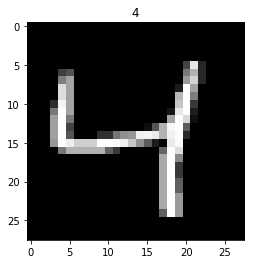

In [3]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

In [4]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
def Binarize(tensor,quant_mode='det'):
    if quant_mode=='det':
        return tensor.sign()
    else:
        return tensor.add_(1).div_(2).add_(torch.rand(tensor.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)

class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        try:
            self.exempt = kwargs["exempt"]
            del kwargs["exempt"]
        except:
            self.exempt=False
        self.exempt=False
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)
        

    def forward(self, input):
        if self.exempt:
#         if input.size(1) != self.excempt:
            input.data=Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
#         print(self.weight.shape)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            BinarizeLinear(28*28, 512, exempt=True),
            nn.Tanh(),
            BinarizeLinear(512, 128),
            nn.Tanh(),
            BinarizeLinear(128, 16),
            nn.Tanh(),
            BinarizeLinear(16, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            BinarizeLinear(3, 16, exempt=True),
            nn.Tanh(),
            BinarizeLinear(16, 128),
            nn.Tanh(),
            BinarizeLinear(128, 512),
            nn.Tanh(),
            BinarizeLinear(512, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

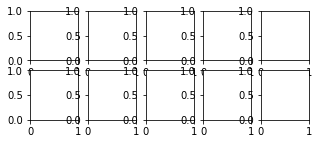

In [7]:
autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

# initialize figure
f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
plt.ion()   # continuously plot

In [8]:
# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
for i in range(N_TEST_IMG):
    a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())

In [9]:
%matplotlib tk

In [10]:
for epoch in range(EPOCH):
    for step, (x, b_label) in enumerate(train_loader):
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()

# visualize in 3D plot
view_data = train_data.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.
encoded_data, _ = autoencoder(view_data)
fig = plt.figure(2); ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = train_data.train_labels[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()

Epoch:  0 | train loss: 0.4613
Epoch:  1 | train loss: 0.4547
Epoch:  2 | train loss: 0.4481
Epoch:  3 | train loss: 0.4430
Epoch:  4 | train loss: 0.4394
Epoch:  5 | train loss: 0.4350
Epoch:  6 | train loss: 0.4312
Epoch:  7 | train loss: 0.4274
Epoch:  8 | train loss: 0.4239
Epoch:  9 | train loss: 0.4199
Epoch:  10 | train loss: 0.4167
Epoch:  11 | train loss: 0.4132
Epoch:  12 | train loss: 0.4102
Epoch:  13 | train loss: 0.4073
Epoch:  14 | train loss: 0.4035
Epoch:  15 | train loss: 0.4013
Epoch:  16 | train loss: 0.3990
Epoch:  17 | train loss: 0.3958
Epoch:  18 | train loss: 0.3944
Epoch:  19 | train loss: 0.3913
Epoch:  20 | train loss: 0.3883
Epoch:  21 | train loss: 0.3862
Epoch:  22 | train loss: 0.3841
Epoch:  23 | train loss: 0.3821
Epoch:  24 | train loss: 0.3794
Epoch:  25 | train loss: 0.3771
Epoch:  26 | train loss: 0.3746
Epoch:  27 | train loss: 0.3716
Epoch:  28 | train loss: 0.3693
Epoch:  29 | train loss: 0.3664
